In [1]:
import pickle

spike_times = pickle.load(open("iris_spikes", 'rb'))

from brian2 import *
%matplotlib inline

#  The documentation for the functions used here
https://brian2.readthedocs.io/en/stable/user/input.html#timed-arrays

In [2]:


# The documentation says:
# TimedArray can take a one-dimensional value array (as above) and therefore return the same value
# for all neurons or it can take a two-dimensional array with time as the first and 
# (neuron/synapse/…-)index as the second dimension.

ta = TimedArray(spike_times[0], dt=1*ms)
ta

# Using the values from the paper and 8 neurons in the input we try to train the first class

Using 
$V_{resting}=-5mV$
meaning  vr = -5*mV. Threshold = $1mV$ is vt = 1*mV. $ The potential is V_{reset}=-5mV=$vr = -5*mV. The refractory period $\tau_{ref}$ is $ref=3ms$. 

### We need to determine
The total incoming current through synapses $I_{syn}(t)$ from the paper

In [3]:
N = 8
ref=3*ms
taum = 10*ms
taupre = 20*ms
taupost = taupre
Ee = 0*mV
vt = 1*mV
vr = -5*mV
El = -74*mV
taue = 5*ms
F = 1000*Hz
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

# Here we want to define an equivalent form of the equation
$\frac{dV}{dt}=\frac{-(V(t)-V_{resting})}{\tau_{m}}+\frac{I_{sym}(t)}{C_{m}}$ 

In [4]:
# We neet to moddify this to fit the paper 
eqs_neurons = '''
dv/dt = (ge * (Ee-vr) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''

In [8]:
input = PoissonGroup(8, rates=F)     # Poisson noise 

#input =ta                                 # Replace with spike_times for class1

In [9]:
neurons = NeuronGroup(1, eqs_neurons, threshold='v>vt', reset='v = vr',
                      method='exact', refractory=ref)

## Here we define the Spike-Timing Dependent Plasticity

In the paper the change is described as:... you know how it looks

$ \Delta w =
\begin{equation}
  D_{it} =
    \begin{cases}
      -\alpha \lambda \cdot \exp(-\frac{t_{pre}-t_{post}}{\tau_{-}}) & \text{if $t_{pre}-t_{post}>0$}\\
      2 & \text{if bank $i$ issues CBs at time $t$}\\
      0 & \text{otherwise}
    \end{cases}       
\end{equation}$

In [10]:
S = Synapses(input, neurons,
             '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             )

In [11]:
S.connect()
S.w = 'rand() * gmax'
mon = StateMonitor(S, 'w', record=[0, 1])
spikemon=SpikeMonitor(neurons)
s_mon = SpikeMonitor(input)

In [12]:
S.w = 'rand() * gmax'
mon = StateMonitor(S, 'w', record=[0, 1])
spikemon=SpikeMonitor(neurons)
s_mon = SpikeMonitor(input)

In [13]:
run(6*ms, report='text')

Starting simulation at t=0. s for a duration of 6. ms
6. ms (100%) simulated in < 1s


WARNING    /home/rodrigo/anaconda3/envs/Neuromorphic-projectt/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  app.launch_new_instance()
 [py.warnings]
  app.launch_new_instance()



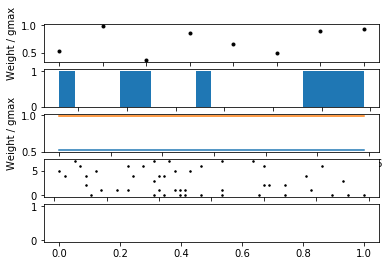

In [14]:
subplot(511)
plot(S.w / gmax, '.k')
ylabel('Weight / gmax')
xlabel('Synapse index')
subplot(512)
hist(S.w / gmax, 20)
xlabel('Weight / gmax')
subplot(513)
plot(mon.t/second, mon.w.T/gmax)
xlabel('Time (s)')
ylabel('Weight / gmax')
subplot(514)
plot(s_mon.t/ms, s_mon.i, '.k', ms=3)
subplot(515)
plot(spikemon.t/ms, spikemon.i, '.k', ms=3)
tight_layout()
show()